In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sys

In [3]:
df = pd.read_csv('airport.csv')
del df["time_of_day"]
del df["booth_rate"]

In [6]:
df["us"] = df["us_avg_wait"]
df["non_us"] = df["non_us_avg_wait"]

In [7]:
df['label'] = 0
for index, row in df.iterrows():
    if row['all_avg_wait']>15:
        df.at[index,'label'] = 1
    else:
        df.at[index,'label'] = 0

In [22]:
X = df.iloc[:,22:34]
y = df.iloc[:,-1] 

In [24]:
#pipe = Pipeline([('scaler', StandardScaler()), ('bestfeatures', SelectKBest(score_func=chi2, k=7))])
bestfeatures = SelectKBest(score_func=chi2, k=7)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(7,'Score'))  #print 10 best features

            Specs         Score
0      passengers  1.095464e+06
11         non_us  2.122630e+05
10             us  8.590340e+04
2          booths  2.476880e+03
1         flights  2.333207e+03
5   early morning  5.939148e+02
9    late evening  4.261540e+02


[0.07806426 0.02461604 0.04280538 0.00386919 0.00059856 0.01266338
 0.00434571 0.00535499 0.00807068 0.00571112 0.28766137 0.52623934]


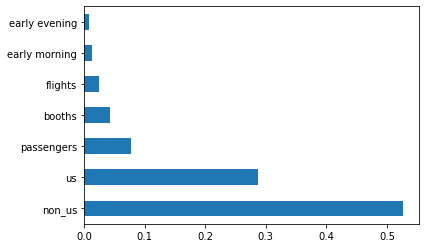

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(7).plot(kind='barh')
plt.show()

In [25]:
X = df[[ "non_us", "us", "booths", "flights", "passengers"]].to_numpy()
y = df[['label']].to_numpy()
y = np.ravel(y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [34]:
from sklearn.tree import DecisionTreeClassifier
tree_train_list = []
index = []
tree_test_list = []
for i in range(100):
    index.append(i+ 1)
    tree = DecisionTreeClassifier(max_depth=i + 1)
    tree.fit(X_train, y_train)
    tree_test_list.append(tree.score(X_test, y_test)) 
    tree_train_list.append(tree.score(X_train, y_train)) 

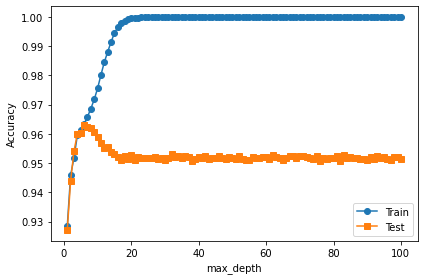

In [35]:
plt.plot(index, tree_train_list, marker='o', label='Train')
plt.plot(index, tree_test_list, marker='s', label='Test')
plt.legend(loc='best', numpoints=1)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.tight_layout()

In [36]:
from sklearn.model_selection import GridSearchCV
tree = DecisionTreeClassifier(random_state=123)

new_list = [None]
for i in range(20):
    new_list.append(i+1)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': new_list
}

gs = GridSearchCV(estimator=tree,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10)

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params: %s' % gs.best_params_)
print('Test Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 96.06%
Best Params: {'criterion': 'gini', 'max_depth': 6}
Test Accuracy: 96.30%


In [37]:
from sklearn.model_selection import GridSearchCV
tree = DecisionTreeClassifier(random_state=123)

new_list = [None]
for i in range(20):
    new_list.append(i+1)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': new_list
}

gs = GridSearchCV(estimator=tree,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10)

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params: %s' % gs.best_params_)
print('Test Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 96.06%
Best Params: {'criterion': 'gini', 'max_depth': 6}
Test Accuracy: 96.30%


In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv_acc = cross_val_score(estimator=gs.best_estimator_,
                         X=X_train,
                         y=y_train,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

from mlxtend.evaluate import bootstrap_point632_score


cv_acc = bootstrap_point632_score(estimator=gs.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  random_seed=99)

print('OOB Bootstrap Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

Kfold Accuracy: 96.09%
OOB Bootstrap Accuracy: 96.04%


In [39]:
from mlxtend.evaluate import bootstrap_point632_score
import numpy as np


# Compute Out-of-bag Bootstrap
scores = bootstrap_point632_score(gs.best_estimator_, X, y, method='oob', random_seed = 1)


# Compute accuracy (average over the bootstrap rounds)
acc = np.mean(scores)
print('Accuracy: %.2f%%' % (100*acc))

# Compute the 95% confidence interval around the accuracy estimate
lower = np.percentile(scores, 2.5)
upper = np.percentile(scores, 97.5)
print('95%% Confidence interval: [%.2f, %.2f]' % (lower, upper))

Accuracy: 96.04%
95% Confidence interval: [0.96, 0.96]


In [28]:
from sklearn.tree import DecisionTreeClassifier
pipe = Pipeline([('scaler', StandardScaler()), ('dicision_tree', DecisionTreeClassifier(max_depth=10))])
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
score

0.9589352042921998

In [29]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10,
                                random_state=123)
forest.fit(X_train, y_train)

print(f"Training Accuracy: {forest.score(X_train, y_train):0.5f}")
print(f"Test Accuracy: {forest.score(X_test, y_test):0.5f}")

Training Accuracy: 0.99726
Test Accuracy: 0.96045


In [12]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10,
                                random_state=123)
forest.fit(X_train, y_train)

print(f"Training Accuracy: {forest.score(X_train, y_train):0.5f}")
print(f"Test Accuracy: {forest.score(X_test, y_test):0.5f}")

Training Accuracy: 0.94454
Test Accuracy: 0.66797


In [40]:
from sklearn.neighbors import KNeighborsClassifier

tree_train_list = []
index = []
tree_test_list = []
for i in range(100):
    index.append(i+ 1)
    knn = KNeighborsClassifier(n_neighbors=i + 1)
    knn.fit(X_train, y_train)
    tree_test_list.append(knn.score(X_test, y_test)) 
    tree_train_list.append(knn.score(X_train, y_train)) 

KeyboardInterrupt: 

In [ ]:
plt.plot(index, tree_train_list, marker='o', label='Train')
plt.plot(index, tree_test_list, marker='s', label='Test')
plt.legend(loc='best', numpoints=1)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.tight_layout()

In [11]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

boost = AdaBoostClassifier(random_state=123)
boost.fit(X_train, y_train)

print(f"Training Accuracy: {boost.score(X_train, y_train)* 100:0.3f}%")
print(f"Test Accuracy: {boost.score(X_test, y_test)*100:0.3f}%")

Training Accuracy: 71.836%
Test Accuracy: 72.238%


In [3]:
from xgboost import XGBClassifier